In [1173]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.colors import LogNorm 

In [1174]:
class StochasticSIR:
    def __init__(self, initial_SIR, beta, gamma, tmax, mu=0):
        self.current_SIR = initial_SIR
        self.SIR = self.initialize()
        self.beta = beta
        self.gamma = gamma
        self.t = [0]
        self.tmax = tmax
        self.mu = mu

    def initialize(self):
        """
        Changes self.current_SIR to a dictionary, each value in the original list being assigned to the corresponding key in the new dictionary, being either 'S', 'I', ''R' or 'N'.
        Creates and returns dictionary with lists for S, I, R, and N. By default, N is the sum of the subpopulations.
        """ 

        S, I, R = self.current_SIR
        self.current_SIR = {'S': S, 'I': I, 'R': R, 'N': S + I + R}
        return {'S': [S], 'I': [I], 'R': [R], 'N': [S + I + R]}

    def infection_event(self):
        """
        Infection event: decreases susceptible population and increase infected population by 1
        """
        
        self.current_SIR['S'] -= 1
        self.current_SIR['I'] += 1

    def recovery_event(self):
        """
        Recovery event: decrease infected population and increased recovered population by 1
        """

        self.current_SIR['I'] -= 1
        self.current_SIR['R'] += 1

    def birth_event(self):
        """
        Recovery event: decrease infected population and increased recovered population by 1
        """

        self.current_SIR['S'] += 1

    def susceptible_death_event(self):
        """
        Susceptible death event: decrease susceptible population by 1
        """ 

        self.current_SIR['S'] -= 1

    def infected_death_event(self):
        """
        Infected death event: decrease infected population by 1
        """

        self.current_SIR['I'] -= 1

    def recovered_death_event(self):
        """
        Recovered death event: decrease recovered population by 1
        """

        self.current_SIR['R'] -= 1

    def update_SIR(self):
        """
        Updates the dictionary containing the dynamics according to the most recent status of the simulation.
        """ 

        S, I, R, N = self.current_SIR.values()
        self.SIR['S'].append(S)
        self.SIR['I'].append(I)
        self.SIR['R'].append(R)
        self.SIR['N'].append(S + I + R)

    def run(self):
        """
        Runs a simulation of the SIR model using the Gillespie algorithm until a specified
        maximum time (tmax) is reached.

        During each time step of the algorithm, the following steps are performed:

        1. Get the most recent values of susceptible (S), infected (I), recovered (R), and total population (N)..
        2. Calculate the probabilities of various events:
            - Event 1: A single infection.
            - Event 2: A single recovery.
            - Event 3: A single birth.
            - Event 4: A single susceptible death.
            - Event 5: A single infected death.
            - Event 6: A single recovered death.
        3. Calculate the length of the current time step (dt) based on exponential distributions
        and the sum of event probabilities.
        4. Add dt to the previous time.
        5. Perform one of the possible events (infection, recovery, birth, or death) based on generated probabilities.
        6. Update the dictionary containing all the disease dynamics (S, I, R).
        """

        # Until tmax is reached. Number of timesteps is unknown, so for-loop is not useful
        while self.t[-1] < self.tmax:

            # Get most recent values of S, I, R and N
            S, I, R, N = self.current_SIR.values()

            # Stop simulation if infected population reaches zero
            if self.mu == 0 and I == 0:
                dt = self.tmax - self.t[-1]
                self.t.append(self.tmax)

            else:

                # Calculate probabilities of event 1 (single infection) and event 2 (single recovery)
                probabilities = [self.beta * S * I / N, self.gamma * I, self.mu *N , self.mu * S, self.mu * I, self.mu * R]
                probabilities_sum = sum(probabilities)
                cumulative_probabilities = [sum(probabilities[:i+1]) for i in range (len(probabilities))]

                # Calculate length current timestep and add it to self.t
                dt= np.random.exponential(scale = 1 / probabilities_sum)
                self.t.append(self.t[-1] + dt)


                P = np.random.uniform(0, 1) * probabilities_sum

                # Do infection or recovery event according to probabilities
                if P < cumulative_probabilities[0]:

                    # 1 susceptible becomes infected
                    self.infection_event()

                # 1 infected becomes recovered
                elif P < cumulative_probabilities[1]:
                    self.recovery_event()

                elif P < cumulative_probabilities[2]:
                    self.birth_event()

                elif P < cumulative_probabilities[3]:
                    self.susceptible_death_event()
                
                elif P < cumulative_probabilities[4]:
                    self.infected_death_event()

                elif P <= cumulative_probabilities[5]:
                    self.recovered_death_event()

            # Update dictionary containing all dynamics
            self.update_SIR()


    def plot(self, ax, std=None, S = True, I = True , R = True, N = True, S_label = 'Susceptible', I_label = 'Infected', R_label = 'Recovered', label=False):
        """
        Plots the dynamics of the model as a function of time. By default, S, I, R and N are shown, but can be removed if needed.
        Takes an ax as input so the figure can be edited outside of this function. Also takes optional figure labels.
        """

        if label:
            label_addition = " stochastic"
        else:
            label_addition = ""
            
        # If the susceptible curve is to be plotted
        if S:
            y = self.SIR['S']
            ax.plot(self.t, y, label=f"{S_label}{label_addition}", color='blue', linewidth='1')

            # If standard deviaation is to be plotted
            if std:
                ax.fill_between(self.t, y - std['S'], y + std['S'], alpha=0.2, color='blue')

        # If the infected curve is to be plotted
        if I:
            y = self.SIR['I']
            ax.plot(self.t, y, label=f"{I_label}{label_addition}", color='green', linewidth='1')

            # If standard deviaation is to be plotted
            if std:
                ax.fill_between(self.t, y - std['I'], y + std['I'], alpha=0.2, color='green')

        # If the recovered curve is to be plotted
        if R:
            y = self.SIR['R']
            ax.plot(self.t, y, label=f"{R_label}{label_addition}", color='purple', linewidth='1')

            # If standard deviaation is to be plotted
            if std:
                ax.fill_between(self.t, y - std['R'], y + std['R'], alpha=0.2, color='purple')

        # If the population size curve is to be plotted
        if N:
            ax.plot(self.t, self.SIR['N'], label=f'Population size{label_addition}', color='orange', linewidth='1')

In [1175]:
class ContinuousSIR:
    def __init__(self, initial_SIR, tmax, dt, beta, gamma, mu=0):
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.tmax = tmax
        self.dt = dt
        self.population_size = sum(initial_SIR)
        self.n_points = int(tmax/dt)
        self.t = np.linspace(0, self.tmax, self.n_points)
        self.sir = self.initiate(initial_SIR)

    def initiate(self, initial_SIR):
        """
        Initiales the array where the results will be stored. Fills in start conditions.
        """ 

        SIR = np.zeros([len(self.t), 4])
        S, I, R = initial_SIR
        N = S + I + R
        SIR[0] = np.array([[S/N, I/N, R/N, N]])
        return SIR

    def get_derivatives(self, y):
        """
        Calculates the time derivative of S, I, and R in the SIR model according to the current values of S I and R, and the values of beta, gamma, mu, nu and rho.
        """

        # Unpack parameters from array
        S, I, R, N = y
        
        dS = self.mu - self.beta * S * I - self.mu * S
        dI = self.beta * S * I - self.gamma * I - self.mu * I
        dR = self.gamma * I - self.mu * R
        dN = dS + dI + dR

        # Return array with values for the time derivatives of S, I, and R. Sets value for N to 0, this will be calculated and adjusted in run()
        return np.array([dS, dI, dR, dN])

    def run(self):
        """
        Numerically approximates the set of differential equations of the SIR model according to the 4th order Runge-Kutta method.
        """

        # For each timestep
        for i in range(len(self.t) - 1):

            # Do timestep according to Runge-Kutta 4th order
            y = self.sir[i]
            k_1 = self.dt * self.get_derivatives(y)
            k_2 = self.dt * self.get_derivatives(y + k_1 / 2.)
            k_3 = self.dt * self.get_derivatives(y + k_2 / 2.)
            k_4 = self.dt * self.get_derivatives(y + k_3)

            # Update values for S, I, R and N
            self.sir[i+1] = y + 1/6 * (k_1 + 2 * k_2 + 2 * k_3 + k_4)
            
        return self.sir

    def plot(self, ax, S = True, I = True , R = True, N = True, S_label = 'Susceptible', I_label = 'Infected', R_label = 'Recovered'):
        """
        Plots the dynamics of the model as a function of time. By default, S, I, R and N are shown, but can be removed if needed.
        Takes an ax as input so the figure can be edited outside of this function. Also takes optional figure labels.
        """

        if S:
            ax.plot(self.t, self.population_size * self.sir[:,0], '--', label=f"{S_label} continuous", color='blue', linewidth='1')
        if I:
            ax.plot(self.t, self.population_size * self.sir[:,1], '--', label=f"{I_label} continuous", color='green', linewidth='1')
        if R:
            ax.plot(self.t, self.population_size * self.sir[:,2], '--', label=f"{R_label} continuous", color='purple', linewidth='1')
        if N:
            ax.plot(self.t, self.sir[:,3], '--', label='Population size continuous', color='orange')


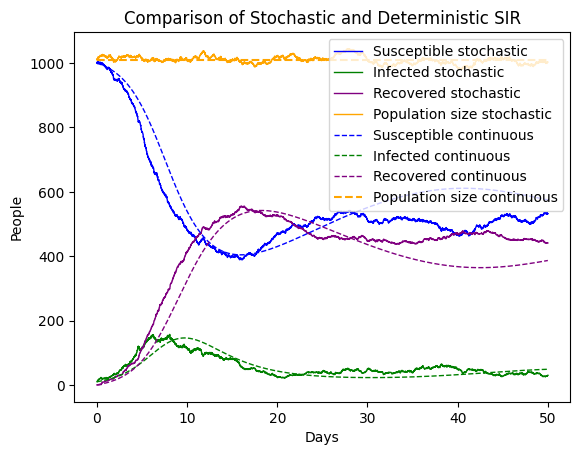

In [1176]:
np.random.seed(2)

# Initial values SIR model
initial_SIR = [1000, 10, 0]
beta = 1
gamma = 0.5
mu = 0.05
tmax = 50

# Run stochastic SIR simulation
infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
infection.run()

# Make ax and generate plot
fig, ax = plt.subplots(1)
infection.plot(ax, label=True)

# Set tmax to highest t in stochastic model
tmax = infection.t[-1]
dt = 0.1

# Run continuous SIR simulation
continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu)
continuous_infection.run()
continuous_infection.plot(ax)

# Compare outcomes of different approaches
plt.title("Comparison of Stochastic and Deterministic SIR")
plt.legend()
plt.xlabel('Days')
plt.ylabel('People')
plt.savefig("StochasticVsDeterministic")
plt.show()

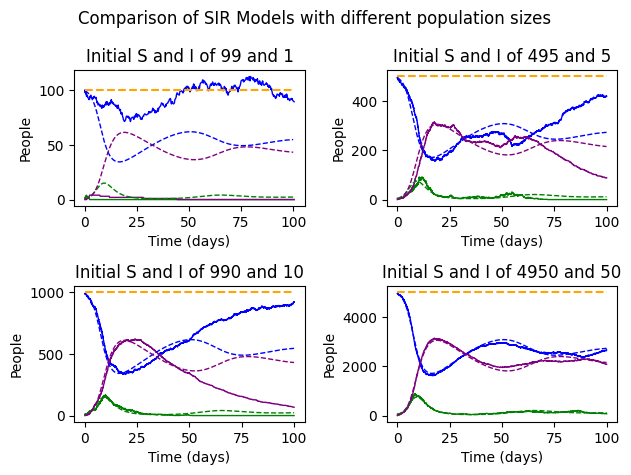

In [1177]:
np.random.seed(1)

# Define the different initial values to compare
initial_SIR= [500, 1, 0]
initial_SIR_values= [
    [99, 1, 0],
    [495, 5, 0],
    [990, 10, 0],
    [4950, 50, 0]
]

mu = 0.03
tmax = 100

beta = 1
gamma = 0.5

for i in range(len(initial_SIR_values)):
    initial_SIR = initial_SIR_values[i]

    infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
    infection.run()
    continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu=mu)
    continuous_infection.run()
    
    plt.subplot(2, 2, i+1)
    plt.title(f"Initial S and I of {initial_SIR[0]} and {initial_SIR[1]}")
    plt.xlabel('Time (days)')
    plt.ylabel('People')
    infection.plot(plt.gca(), N=False, label=True)
    continuous_infection.plot(plt.gca())

# Compare outcomes of different runs
plt.suptitle("Comparison of SIR Models with different population sizes")
plt.tight_layout()
plt.show()

In [1178]:
class Analyze:
    def __init__(self, N, tmax, initial_SIR, beta, gamma, dt = 0.001, mu = 0):
        self.N = N
        self.N_timesteps = int(tmax / dt)
        self.t = [i * dt for i in range(self.N_timesteps - 1)]
        self.results = {'S': {i: [0 for j in range(N)] for i in self.t},
                        'I': {i: [0 for j in range(N)] for i in self.t},
                        'R': {i: [0 for j in range(N)] for i in self.t}}
        
        self.average = []
        self.std = []
        self.initial_SIR = initial_SIR
        self.gamma = gamma
        self.beta = beta
        self.tmax = tmax
        self.mu = mu

    def convert_regular_timesteps(self):
        """
        Convert stochastic SIR simulation results with irregular timesteps to regular timesteps.

        This function performs N runs of a stochastic SIR simulation and converts the resulting
        irregularly sampled data to a set of regular timesteps. It extracts the dynamics of
        susceptible (S), infected (I), and recovered (R) individuals and stores them in 'results'.
        """ 

        # Perform N runs
        for run in range(self.N):

            # Run stochastic SIR simulation
            infection = StochasticSIR(self.initial_SIR, self.beta, self.gamma, self.tmax, self.mu)
            infection.run()

            # Extract dynamics
            stocastic_SIR = infection.SIR
            stochastic_t = infection.t
            
            self.results['S'][0][run] = stocastic_SIR['S'][0]
            self.results['I'][0][run] = stocastic_SIR['I'][0]
            self.results['R'][0][run] = stocastic_SIR['R'][0]

            # Set initial values for stochastic timestep
            t_index = 1
            next_stochastic_t = stochastic_t[t_index]

            previous_t = self.t[0]
            
            # For each timestep
            for current_t in self.t:

                # If current timestep is before the next timestep of the stochastic SIR simulation
                if current_t < next_stochastic_t:

                    self.results['S'][current_t][run] = self.results['S'][previous_t][run]
                    self.results['I'][current_t][run] = self.results['I'][previous_t][run]
                    self.results['R'][current_t][run] = self.results['R'][previous_t][run]

                # If current timestep is after the next timestep of the stochastic SIR simulation
                else:

                    self.results['S'][current_t][run] = stocastic_SIR['S'][t_index]
                    self.results['I'][current_t][run] = stocastic_SIR['I'][t_index]
                    self.results['R'][current_t][run] = stocastic_SIR['R'][t_index]

                    # Increase stochastic time index and next timestep
                    t_index += 1
                    next_stochastic_t = stochastic_t[t_index]

                    previous_t = current_t
                    
    def get_average(self):
        """
        Calculate average SIR population values over multiple runs at every timestep.
        """

        return {'S': np.array([np.mean(self.results['S'][i]) for i in self.t]),
                'I': np.array([np.mean(self.results['I'][i]) for i in self.t]),
                'R': np.array([np.mean(self.results['R'][i]) for i in self.t])}
    
    def get_std(self):
        """
        Calculate standard deviation of SIR population values over multiple runs at every timestep.
        """

        return {'S': np.array([np.std(self.results['S'][i]) for i in self.t]),
                'I': np.array([np.std(self.results['I'][i]) for i in self.t]),
                'R': np.array([np.std(self.results['R'][i]) for i in self.t])}
    
    def get_covariance(self):
        """
        Calculate the covariance between the susceptible (S) and infected (I) population over time.
        Returns a list of covariance values corresponding to different time steps.
        """

        if len(self.average) == 0:
            self.average = self.get_average()

        covariance = []
        for index, i in enumerate(self.t):
            covariance.append(np.sum([(self.results['S'][i][j] - self.average['S'][index]) * (self.results['I'][i][j] - self.average['I'][index]) for j in range(self.N)]) / (self.N - 1))
        
        return covariance


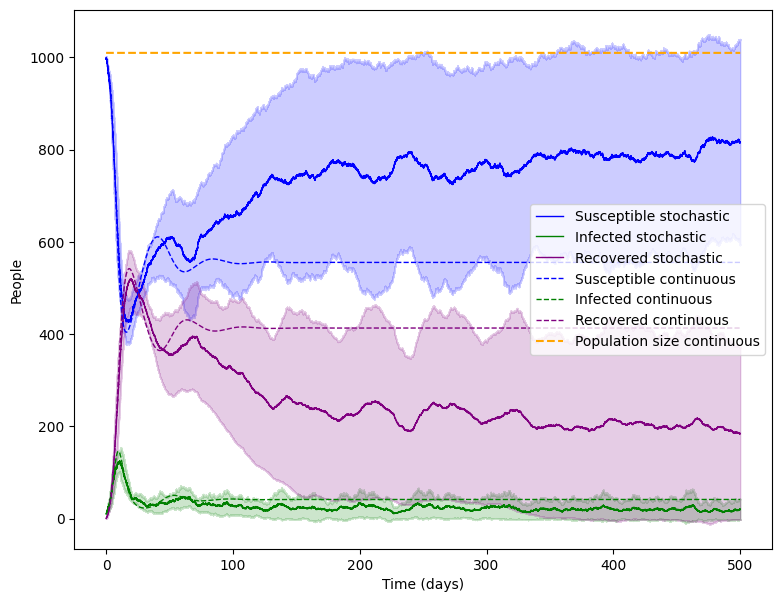

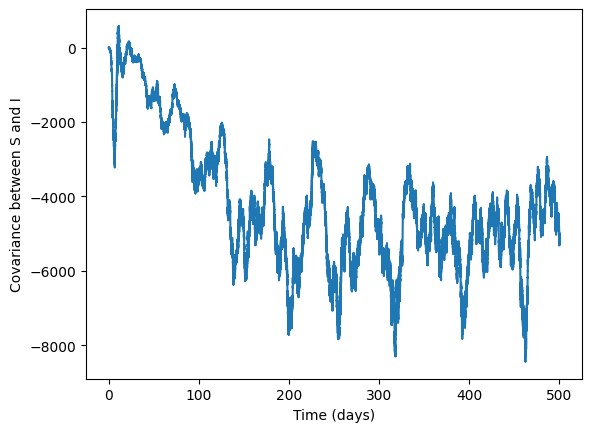

In [1179]:
np.random.seed(0)

# Initial values SIR model
initial_SIR = [1000, 10, 0]
beta = 1
gamma = 0.5
mu = 0.05
tmax = 500
N_runs = 10

analysis = Analyze(N_runs, tmax, initial_SIR, beta, gamma, mu=mu)
analysis.convert_regular_timesteps()
average = analysis.get_average()
std = analysis.get_std()
covariance = analysis.get_covariance()
t = analysis.t

infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
infection.SIR = average
infection.t = t

fig, ax = plt.subplots(1, figsize=(9, 7))
infection.plot(ax, std=std, N=False, label=True)

dt = 0.1

# Run continuous SIR simulation
continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu=mu)
continuous_infection.run()
continuous_infection.plot(ax)

# Compare outcomes of different approaches
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('People')
plt.savefig("StochasticAvgVsDeterministic")
plt.show()

plt.plot(t, covariance)
plt.xlabel('Time (days)')
plt.ylabel('Covariance between S and I')
plt.show()

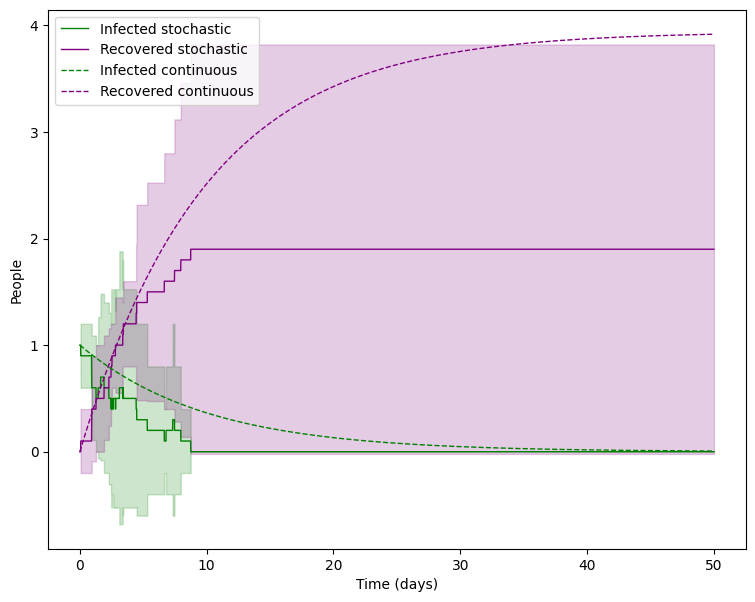

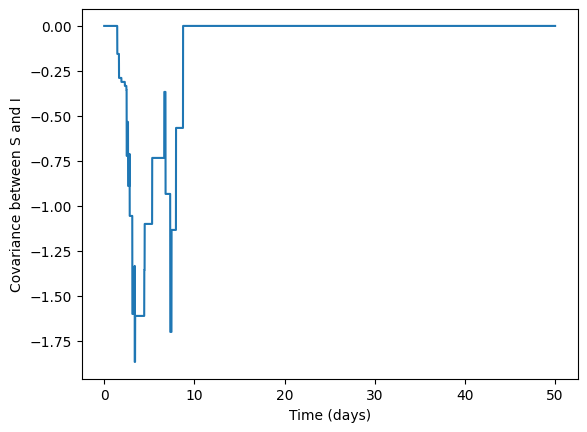

In [1180]:
# Initial values SIR model
initial_SIR = [500, 1, 0]
beta = 0.3
gamma = 0.4
tmax = 50
N_runs = 10

analysis = Analyze(N_runs, tmax, initial_SIR, beta, gamma)
analysis.convert_regular_timesteps()
average = analysis.get_average()
std = analysis.get_std()
covariance = analysis.get_covariance()
t = analysis.t

infection = StochasticSIR(initial_SIR, beta, gamma, tmax)
infection.SIR = average
infection.t = t

fig, ax = plt.subplots(1, figsize=(9, 7))
infection.plot(ax, std=std, N=False, label=True, S=False)

dt = 0.1

# Run continuous SIR simulation
continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma)
continuous_infection.run()
continuous_infection.plot(ax, S=False, N=False)

# Compare outcomes of different approaches
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('People')
plt.show()

plt.plot(t, covariance)
plt.xlabel('Time (days)')
plt.ylabel('Covariance between S and I')
plt.show()

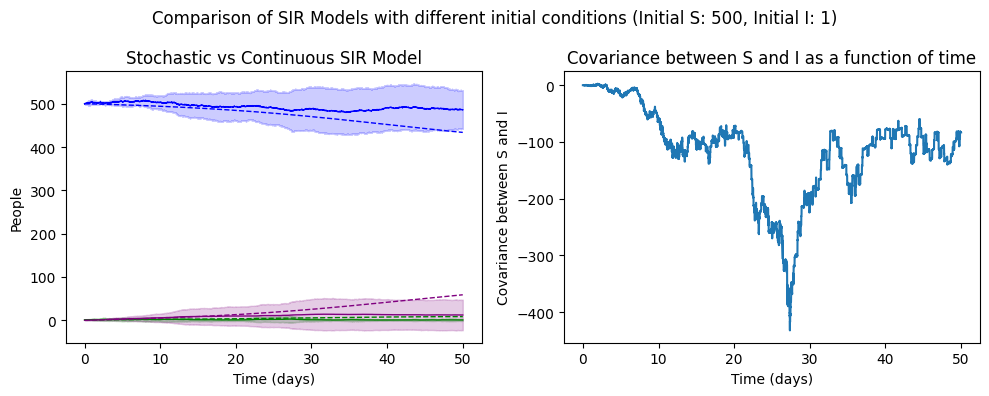

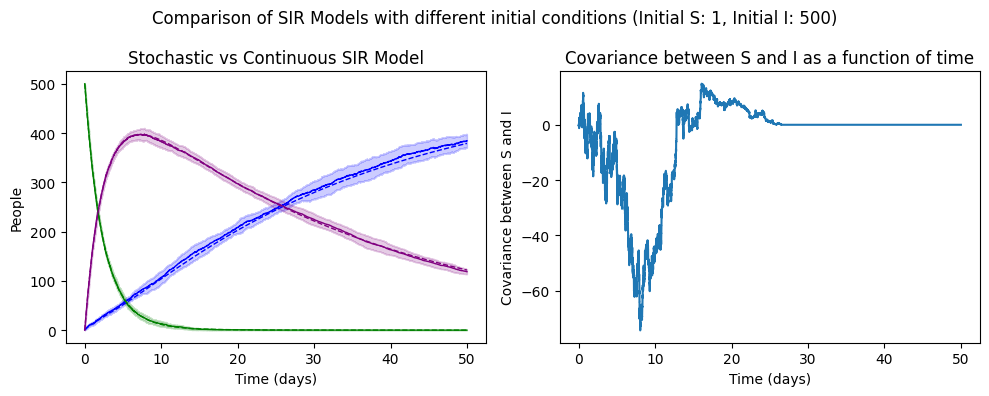

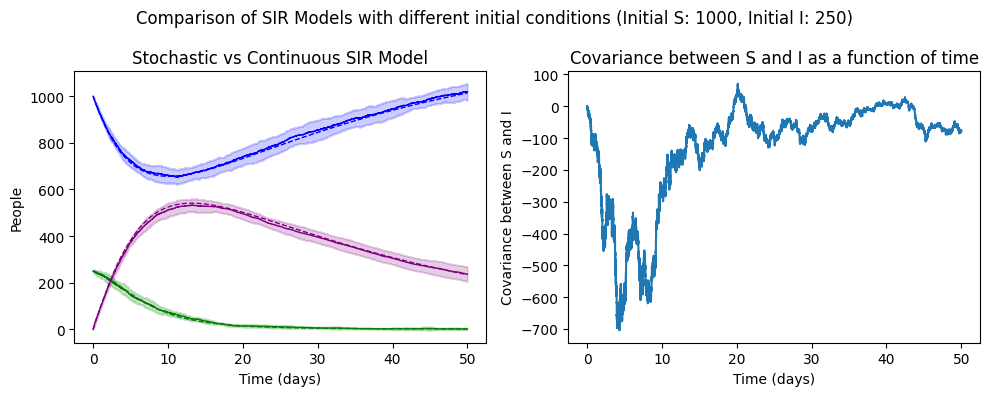

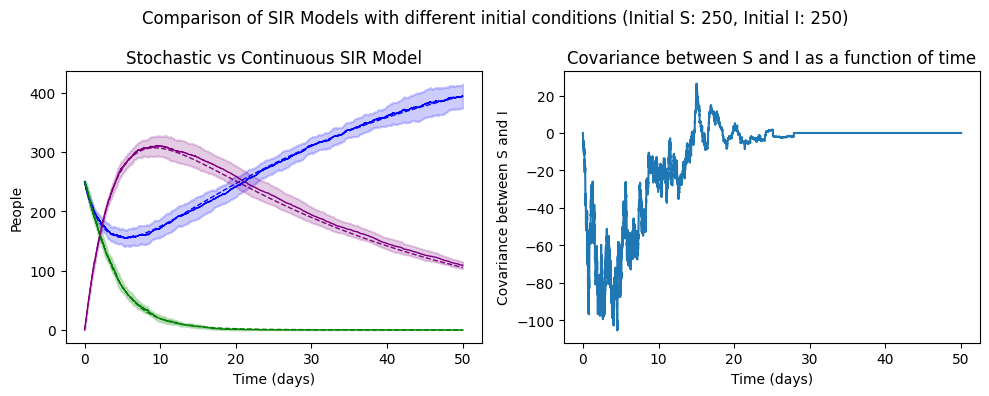

In [1181]:
# Define the initial values
initial_SIR_values = [
    [500, 1, 0],
    [1, 500, 0],
    [1000, 250, 0],
    [250, 250, 0]
]
beta = 0.5
gamma = 0.4
mu = 0.03
tmax = 50
N_runs = 10

# Iterate through initial conditions and create separate figures
for i in range(len(initial_SIR_values)):
    initial_SIR = initial_SIR_values[i]
    analysis = Analyze(N_runs, tmax, initial_SIR, beta, gamma, mu=mu)
    analysis.convert_regular_timesteps()
    average = analysis.get_average()
    std = analysis.get_std()
    covariance = analysis.get_covariance()
    t = analysis.t

    infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
    infection.SIR = average
    infection.t = t
    continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu=mu)
    continuous_infection.run()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"Comparison of SIR Models with different initial conditions (Initial S: {initial_SIR[0]}, Initial I: {initial_SIR[1]})")

    axes[0].set_title(f"Stochastic vs Continuous SIR Model")
    axes[0].set_xlabel('Time (days)')
    axes[0].set_ylabel('People')
    infection.plot(axes[0], std=std, N=False, label=True)
    continuous_infection.plot(axes[0],  N=False)

    
    axes[1].plot(t, covariance)   
    axes[1].set_title(f"Covariance between S and I as a function of time")
    axes[1].set_xlabel('Time (days)')
    axes[1].set_ylabel('Covariance between S and I')

    fig.tight_layout()
    plt.show()


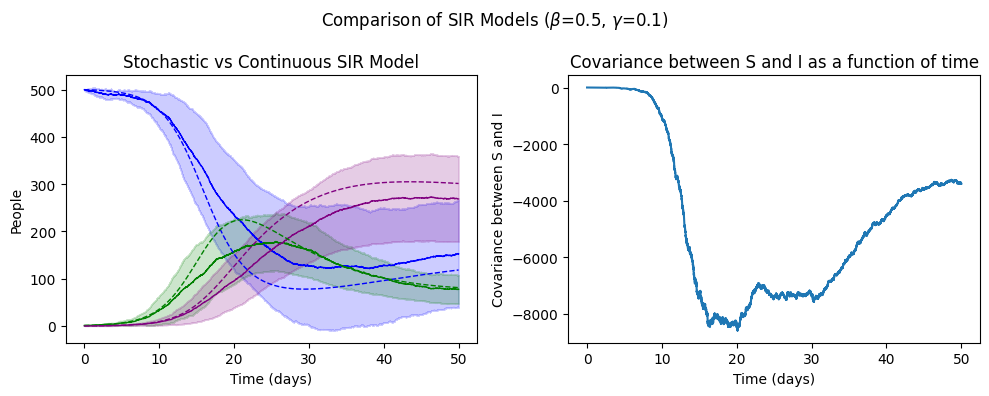

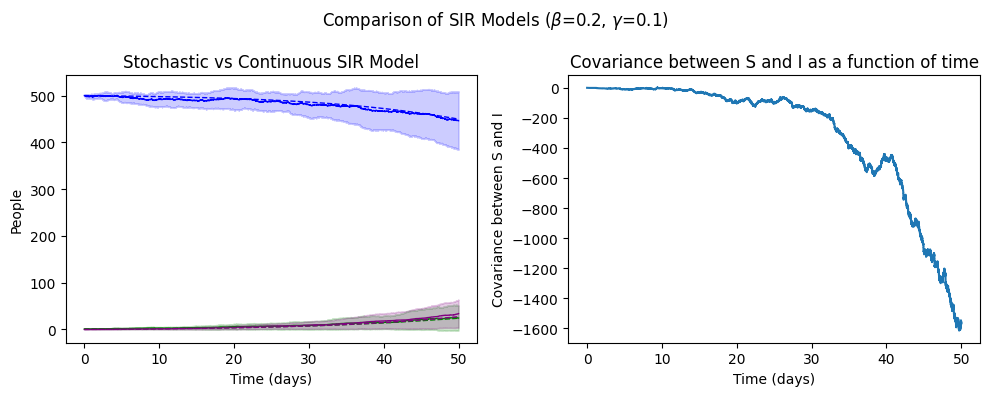

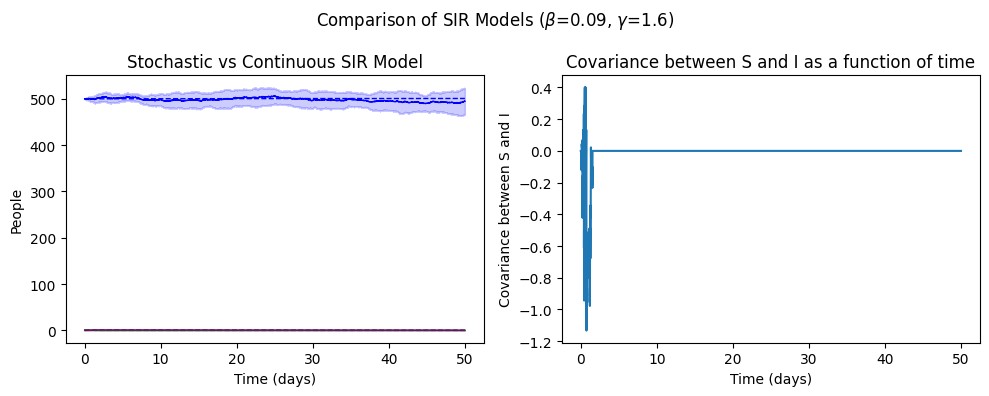

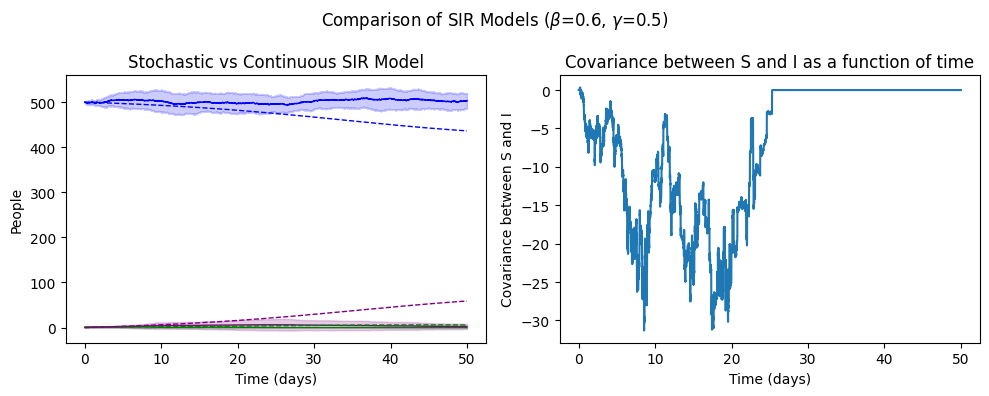

In [1182]:
# Define the different initial values to compare
initial_SIR = [500, 1, 0]
beta_gamma = [
    [0.5, 0.1],
    [0.2, 0.1],
    [0.09, 1.6],
    [0.6, 0.5]
]
mu = 0.03
tmax = 50
N_runs = 10

# Iterate through different beta and gamma values
for i in range(len(beta_gamma)):
    beta, gamma = beta_gamma[i][0], beta_gamma[i][1]
    analysis = Analyze(N_runs, tmax, initial_SIR, beta, gamma, mu=mu)
    analysis.convert_regular_timesteps()
    average = analysis.get_average()
    std = analysis.get_std()
    covariance = analysis.get_covariance()
    t = analysis.t

    infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
    infection.SIR = average
    infection.t = t
    continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu=mu)
    continuous_infection.run()

    # Create a new figure for each set of beta and gamma values
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(fr"Comparison of SIR Models ($\beta$={beta}, $\gamma$={gamma})")

    axes[0].set_title(f"Stochastic vs Continuous SIR Model")
    axes[0].set_xlabel('Time (days)')
    axes[0].set_ylabel('People')
    infection.plot(axes[0], std=std, N=False, label=True)
    continuous_infection.plot(axes[0],  N=False)

    axes[1].plot(t, covariance)   
    axes[1].set_title(f"Covariance between S and I as a function of time")
    axes[1].set_xlabel('Time (days)')
    axes[1].set_ylabel('Covariance between S and I')

    fig.tight_layout()
    plt.show()

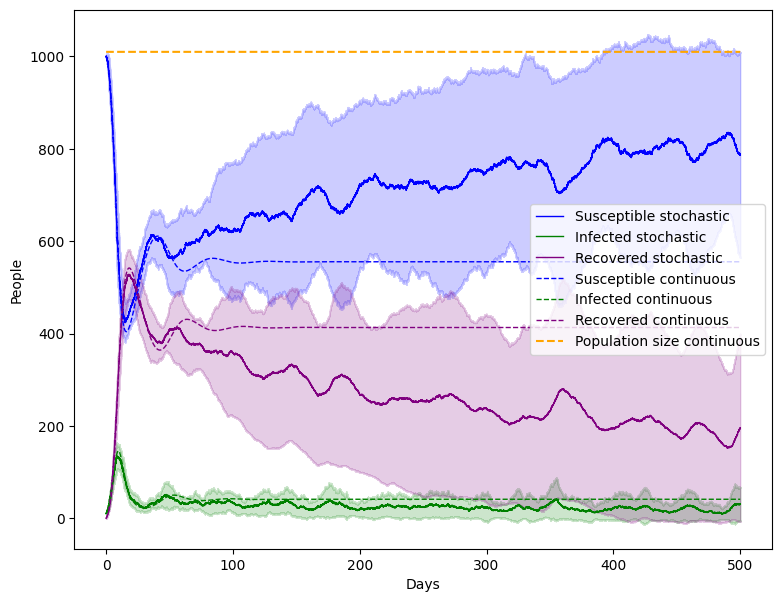

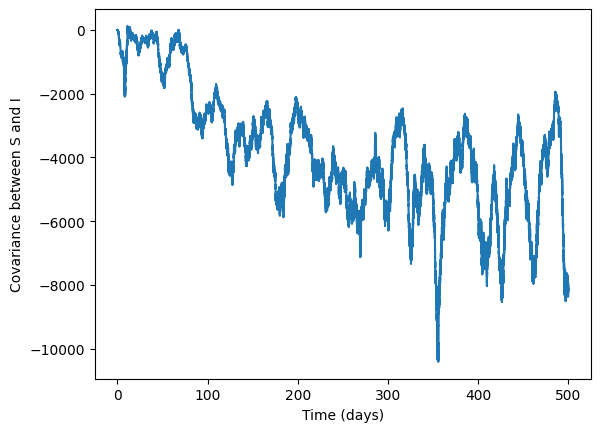

In [1183]:
# Initial values SIR model
initial_SIR = [1000, 10, 0]
beta = 1
gamma = 0.5
mu = 0.05
tmax = 500
N_runs = 10

analysis = Analyze(N_runs, tmax, initial_SIR, beta, gamma, mu=mu)
analysis.convert_regular_timesteps()
average = analysis.get_average()
std = analysis.get_std()
covariance = analysis.get_covariance()
t = analysis.t

infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
infection.SIR = average
infection.t = t

fig, ax = plt.subplots(1, figsize=(9, 7))
infection.plot(ax, std=std, N=False, label=True)

dt = 0.1

# Run continuous SIR simulation
continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu=mu)
continuous_infection.run()
continuous_infection.plot(ax)

# Compare outcomes of different approaches
plt.legend()
plt.xlabel('Days')
plt.ylabel('People')
plt.show()

plt.plot(t, covariance)
plt.xlabel('Time (days)')
plt.ylabel('Covariance between S and I')
plt.show()

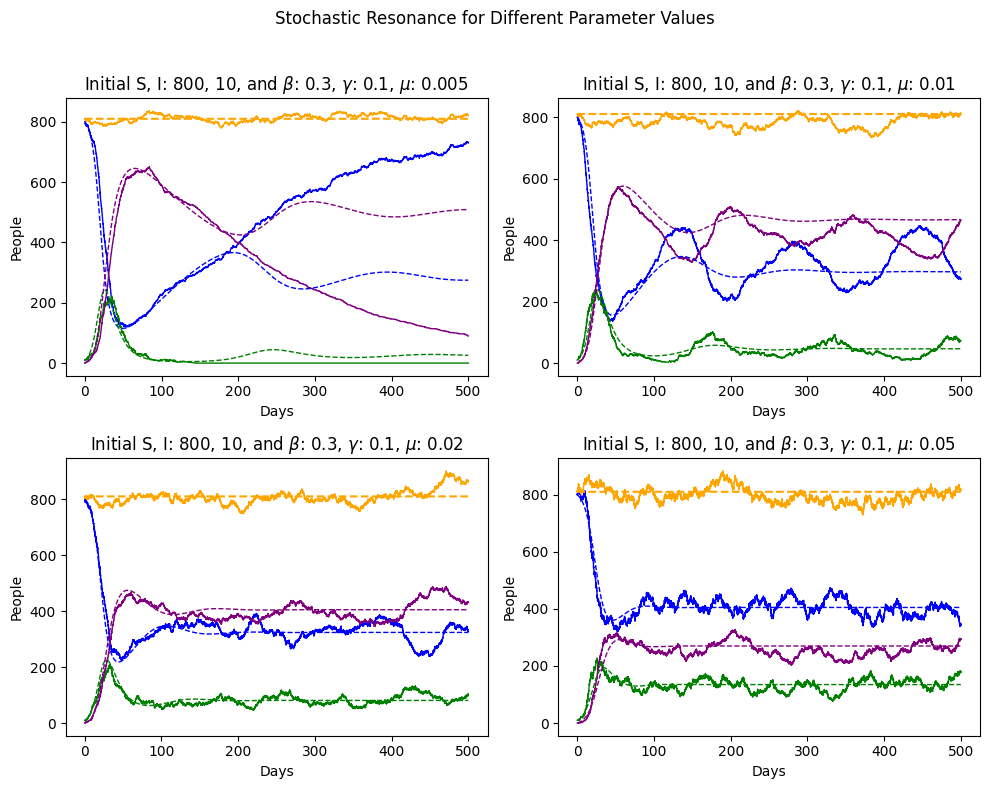

In [1184]:
seeds = [1, 0, 0, 3]

# Define the different parameter combinations to investigate
parameters = [
    [[800, 10, 0], 0.3, 0.1, 0.005],
    [[800, 10, 0], 0.3, 0.1, 0.01],
    [[800, 10, 0], 0.3, 0.1, 0.02],
    [[800, 10, 0], 0.3, 0.1, 0.05]
]
tmax = 500

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Stochastic Resonance for Different Parameter Values")

for i, (initial_SIR, beta, gamma, mu) in enumerate(parameters):
    np.random.seed(seeds[i])
    row = i // 2
    col = i % 2

    # Create an individual subplot for each parameter combination
    ax = axs[row, col]

    # Run stochastic SIR simulation
    infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
    infection.run()

    # Set tmax to the highest t in the stochastic model
    tmax = infection.t[-1]
    dt = 0.1

    # Run continuous SIR simulation
    continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu)
    continuous_infection.run()

    # Generate the plot in the current subplot
    infection.plot(ax, label="Stochastic SIR")
    continuous_infection.plot(ax)

    ax.set_title(fr"Initial S, I: {initial_SIR[0]}, {initial_SIR[1]}, and $\beta$: {beta}, $\gamma$: {gamma}, $\mu$: {mu}")
    ax.set_xlabel('Days')
    ax.set_ylabel('People')

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig("Stochastic_Resonance.png")
plt.show()

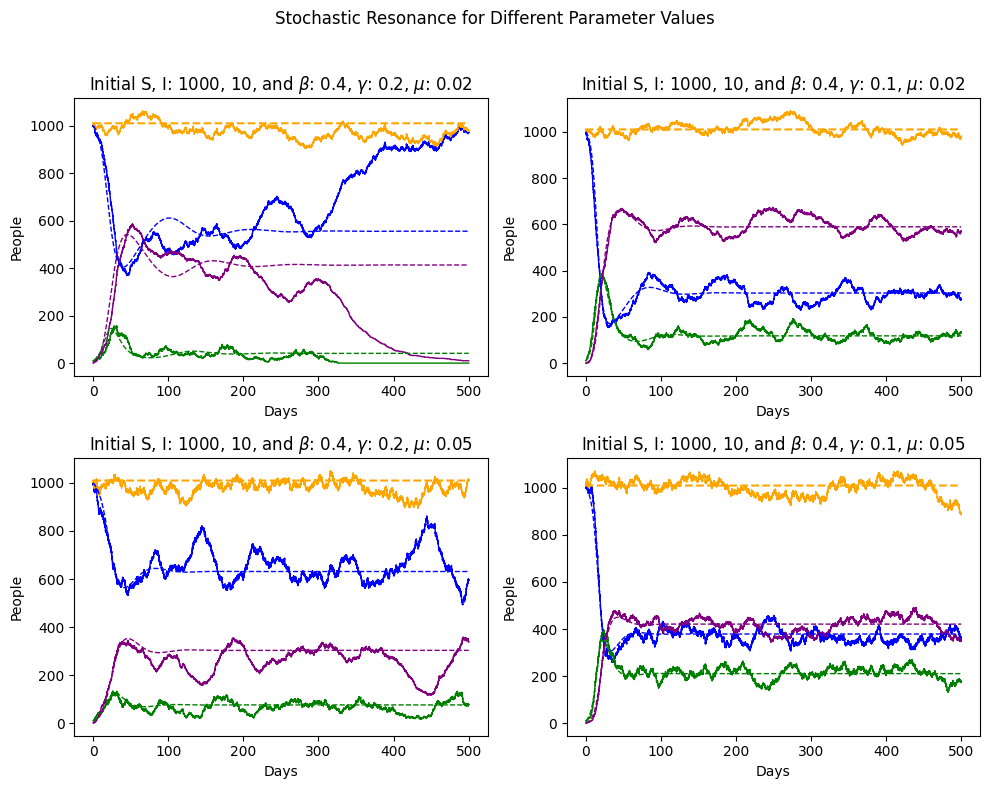

In [1185]:
seeds = [1, 6, 1, 3]

parameters = [
    [0.4, 0.2, 0.02],
    [0.4, 0.1, 0.02],
    [0.4, 0.2, 0.05],
    [0.4, 0.1, 0.05]
]
initial_SIR = [1000, 10, 0]
tmax = 500

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Stochastic Transients for Different Parameter Values")

for i, (beta, gamma, mu) in enumerate(parameters):
    np.random.seed(seeds[i])
    row = i // 2
    col = i % 2

    # Create an individual subplot for each parameter combination
    ax = axs[row, col]

    # Run stochastic SIR simulation
    infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
    infection.run()

    # Set tmax to the highest t in the stochastic model
    tmax = infection.t[-1]
    dt = 0.1

    # Run continuous SIR simulation
    continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu)
    continuous_infection.run()

    # Generate the plot in the current subplot
    infection.plot(ax, label="Stochastic SIR")
    continuous_infection.plot(ax)

    ax.set_title(fr"Initial S, I: {initial_SIR[0]}, {initial_SIR[1]}, and $\beta$: {beta}, $\gamma$: {gamma}, $\mu$: {mu}")
    ax.set_xlabel('Days')
    ax.set_ylabel('People')

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig("Stochastic_Transients.png")
plt.show()

In [1186]:
class InvestigateExtinction:
    def __init__(self, N_min, N_max, R_min, R_max, N_runs, resolution, varying_parameter, smoothing_resolution, tmax):
        self.N_min = N_min
        self.N_max = N_max
        self.R_min = R_min
        self.R_max = R_max
        self.N_runs = N_runs
        self.resolution = resolution
        self.varying_parameter = varying_parameter
        self.smoothing_resolution = smoothing_resolution
        self.tmax = tmax


    def get_extinction_duration(self, N, R):
        """
        Calculate the average time it takes for an infection to become extinct in a series of Stochastic SIR simulations.

        Returns:
        float: The average time to extinction over multiple simulation runs.
        """

        initial_SIR = [int(N  * 0.95), int(N * 0.05), 0]
        mu = 0.05

        if self.varying_parameter == 'gamma':
            beta = 1
            gamma = (beta / R) - mu
        elif self.varying_parameter == 'beta':
            gamma = 1
            beta = R * (gamma + mu)

        extinction_t = 0
        for run in range(self.N_runs):
            infection = StochasticSIR(initial_SIR, beta, gamma, self.tmax, mu=mu)
            infection.run()
            t = infection.t
            extinction_t +=  next((i for index, i in enumerate(t) if infection.SIR['I'][index] == 0), self.tmax) / self.N_runs
        return extinction_t
    
    def get_extinction_data(self):
        """
        Calculate the duration until extinction for various combinations of population size N and reproductive number R_0.

        Returns:
        tuple: A tuple containing three elements - 
        1. extinction_data (list of lists): Duration until extinction for different population sizes and reproductive numbers.
        2. N_values (numpy.ndarray): An array of population size values.
        3. R_values (numpy.ndarray): An array of reproductive number values.
        """

        N_values = np.linspace(self.N_min, self.N_max, self.resolution)
        R_values = np.linspace(self.R_min, self.R_max, self.resolution)

        extinction_data = []
        for R in R_values:
            Ns = []
            for N in N_values:
                Ns.append(self.get_extinction_duration(N, R))
            extinction_data.append(Ns)
            
        return extinction_data, N_values, R_values
    
    def smooth_data(self, N_values, R_values, extinction_data):
        """
        Smooth the extinction data using 2D linear interpolation.

        Args:
        N_values (numpy.ndarray): An array of population size values.
        R_values (numpy.ndarray): An array of reproductive number values.
        extinction_data (list of lists): Duration until extinction for different population sizes and reproductive numbers.

        Returns:
        numpy.ndarray: Smoothed extinction data using 2D linear interpolation.
        """

        interp_func = interpolate.interp2d(N_values, R_values, extinction_data, kind='linear')
        N_values_fine = np.linspace(self.N_min, self.N_max, self.smoothing_resolution)
        R_values_fine = np.linspace(self.R_min, self.R_max, self.smoothing_resolution)
        return interp_func(N_values_fine, R_values_fine)


    def investigate_extinction(self):
        """
        Investigate the duration of extinction events for various population sizes and reproductive numbers.

        This function first calculates the duration of extinction events for a range of population sizes and
        reproductive numbers. It then applies smoothing to the obtained data using 2D linear interpolation.

        Returns:
        numpy.ndarray: Smoothed data representing the duration of extinction events for different population sizes and reproductive numbers.
        """

        extinction_data, N_values, R_values = self.get_extinction_data()
        extinction_data = self.smooth_data(N_values, R_values, extinction_data)
        return extinction_data


    def plot_extinction(self, extinction_data):
        """
        Plot a heatmap of the average stochastic extinction time over a range of population sizes and reproductive numbers.

        Args:
        extinction_data (numpy.ndarray): Smoothed data representing the duration of extinction events for different population sizes and reproductive numbers.
        """

        # Create the imshow plot using the high-resolution p values
        plt.imshow(extinction_data, origin='lower',  extent=[self.N_min, self.N_max, self.R_min, self.R_max], aspect='auto', norm=LogNorm(0.1, 500))

        colorbar = plt.colorbar(label=f'Average stochastic extinction time over {self.N_runs} runs')
        colorbar.set_ticks([0.1, 1, 10, 100, 500])
        colorbar.set_ticklabels(['0.1', '1', '10', '100', 'No extinction'])

        plt.xlabel('N')
        plt.ylabel(r'R$_0$')
        plt.xticks([20, 250, 500, 750, 1000, 1250, 1500, 1750, 2000])
        plt.yticks([0.1, 0.5, 1, 1.5, 2, 2.5, 3])
        plt.title(fr'Average stochastic extinction time for various values for N and $\{self.varying_parameter}$')
        plt.tight_layout()
        plt.show()

C:\Users\jaspe\AppData\Local\Temp\ipykernel_17768\3881912330.py:76: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  interp_func = interpolate.interp2d(N_values, R_values, extinction_data, kind='linear')
C:\Users\jaspe\AppData\Local\Temp\ipykernel_17768\3881912330.py:79: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids,

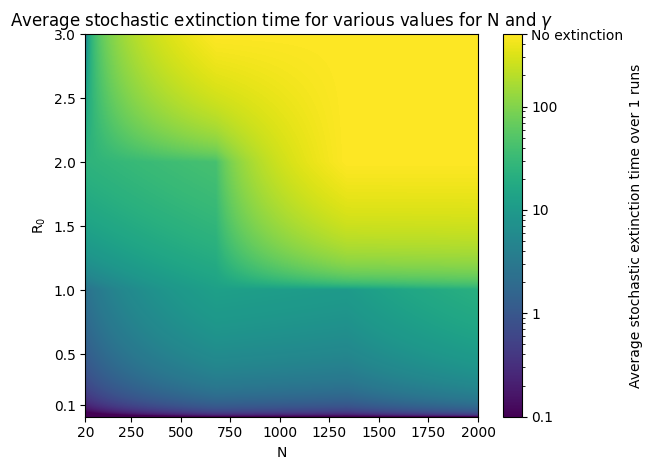

In [1187]:
# Define the range for N and R
N_min, N_max = 20, 2000
R_min, R_max = 0.01, 3
N_runs = 1
resolution = 4
varying_parameter = 'gamma'
smoothing_resolution = 1000
investigation = InvestigateExtinction(N_min, N_max, R_min, R_max, N_runs, resolution, varying_parameter, smoothing_resolution, tmax)
extinction_data = investigation.investigate_extinction()
investigation.plot_extinction(extinction_data)

C:\Users\jaspe\AppData\Local\Temp\ipykernel_17768\3881912330.py:76: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  interp_func = interpolate.interp2d(N_values, R_values, extinction_data, kind='linear')
C:\Users\jaspe\AppData\Local\Temp\ipykernel_17768\3881912330.py:79: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids,

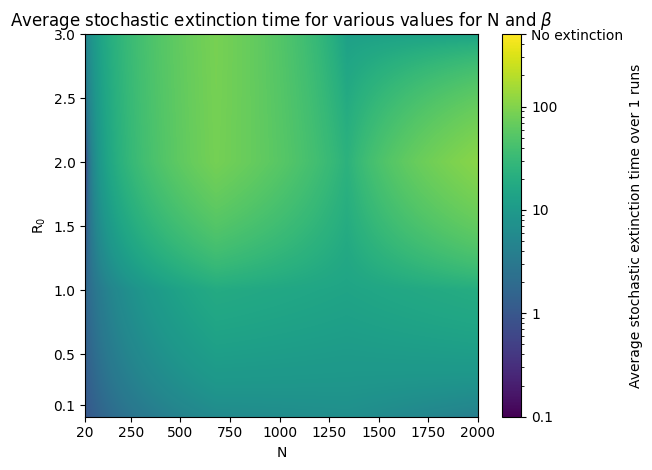

In [1188]:
# Define the range for N and R
N_min, N_max = 20, 2000
R_min, R_max = 0.01, 3
N_runs = 1
resolution = 4
varying_parameter = 'beta'
smoothing_resolution = 1000
investigation = InvestigateExtinction(N_min, N_max, R_min, R_max, N_runs, resolution, varying_parameter, smoothing_resolution, tmax)
extinction_data = investigation.investigate_extinction()
investigation.plot_extinction(extinction_data)

In [1189]:
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import pandas as pd

In [1190]:
def get_graph_statistics(graph, plot_degree_distribution=True):
    """
    Calculate various statistics for a network graph.

    Args:
        graph (networkx.Graph): The input network graph.
        plot_degree_distribution (bool): Whether to plot the degree distribution. Default is True.

    Returns:
        dict: A dictionary containing various network statistics.

    This function calculates a set of statistics for the given network graph, including degree centrality, 
    betweenness centrality, closeness centrality, degree distribution, average path length, longest path length, 
    diameter, and the number of edges.

    If 'plot_degree_distribution' is set to True, a degree distribution plot is also generated.

    The results are returned as a dictionary with keys for each statistic and their respective values.
    """

    # Calculate statistics
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    all_degrees = list(dict(graph.degree()).values())
    N_edges = graph.number_of_edges()
    try:
        diameter = nx.diameter(graph)
    except:
        diameter = np.inf

    all_pairs_paths = dict(nx.all_pairs_shortest_path_length(graph))
    all_path_lengths = [length for source_paths in all_pairs_paths.values() for length in source_paths.values()]

    # Make dictionaries containing statistics
    degree_centrality = {
        "min": min(degree_centrality.values()),
        "max": max(degree_centrality.values()),
        "average": sum(degree_centrality.values()) / len(degree_centrality)
    }

    degree = {
        "min": min(all_degrees),
        "max": max(all_degrees),
        "average": sum(all_degrees) / len(all_degrees)
    }

    betweenness = {
        "min": min(betweenness_centrality.values()),
        "max": max(betweenness_centrality.values()),
        "average": sum(betweenness_centrality.values()) / len(betweenness_centrality)
    }

    closeness = {
        "min": min(closeness_centrality.values()),
        "max": max(closeness_centrality.values()),
        "average": sum(closeness_centrality.values()) / len(closeness_centrality)
    }

    avg_path_length = sum(all_path_lengths) / len(all_path_lengths)
    longest_path_length = max(all_path_lengths)

    if plot_degree_distribution:
        plt.hist(all_degrees, bins=20, alpha=0.5)
        plt.xlabel('Degree')
        plt.ylabel('Count')
        plt.title('Degree Distribution')
        plt.show()

    return {
        "degree": degree,
        "degree centrality": degree_centrality,
        "betweenness": betweenness,
        "closeness": closeness,
        "average path length": avg_path_length,
        "longest path length": longest_path_length,
        "diameter": diameter,
        "number of edges": N_edges
    }

In [1191]:
def read_data(filename):
    """
    Read data from a CSV file and create a network graph.

    Args:
        filename (str): The path to the CSV file containing network data.

    Returns:
        networkx.Graph: A network graph representing the data.

    This function reads data from a CSV file with ';' delimiter and creates a network graph from the data.
    The nodes in the graph correspond to entities in the data, and edges represent relationships or connections.
    The graph is returned as a networkx.Graph object.
    """

    df = pd.read_csv(filename, delimiter = ';', index_col=0)

    # Create the network from given external transmission network
    graph = nx.Graph()
    for node1 in df.index:
        graph.add_node(node1)
        for node2 in df.columns:
            transmission = df.loc[node1, node2]

            if transmission > 0 and not graph.has_edge(node1, node2):
                node2_int = int(node2)
                graph.add_edge(node1, node2_int)
    
    return graph

In [1192]:
def plot_graph(graph, infected_nodes = []):
    """
    Plot a network graph with node colors to visualize infected nodes.

    Args:
        graph (networkx.Graph): The network graph to be plotted.
        infected_nodes (list, optional): A list of nodes that are infected and should be highlighted.
            Defaults to an empty list.
    """

    node_colors = ['orange' if node in infected_nodes else 'purple' for node in graph.nodes()]
    options = {"node_size": 5, "node_color": node_colors, "width": 0.3}
    nx.draw(graph, **options)
    plt.show()

In [1193]:
def infect_network(graph, beta, gamma, N_iterations, I_initial = 5, infected_nodes = None):
    """
    Simulate disease spread on a network using the SIR model.

    Args:
        graph (networkx.Graph): The network graph.
        beta (float): Infection rate.
        gamma (float): Recovery rate.
        N_iterations (int): The number of iterations for the simulation.
        I_initial (int, optional): The initial number of infected nodes. Defaults to 5.
        infected_nodes (list of int, optional): A list of nodes initially infected. Defaults to None.

    Returns:
        model:
            Information about the epidemic simulation.

        iterations:
            A list of dictionaries, each containing information about the epidemic status at each iteration.
    """

    # Set model parameters
    model = ep.SIRModel(graph)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta) 
    cfg.add_model_parameter('gamma', gamma)

    if infected_nodes is None:
        cfg.add_model_parameter("initial_infected_nodes", I_initial)
    else:
        cfg.add_model_parameter("initial_infected_nodes", infected_nodes)

    model.set_initial_status(cfg)

    # Perform simulation 
    iterations = model.iteration_bunch(N_iterations, node_status=False)

    return model, iterations

In [1194]:
def print_statistics(statistic, values):
    """
    Print minimum, maximum, and average values of certain statistics.

    Args:
        statistic (str): The name of the statistic.
        values (dict or float): Dictionary containing minimum (min), maximum (max), and average (average) values
                                or a single float value.
    """

    print(f"{statistic}:")
    try:
        print(f"  Minimum: {values['min']}")
        print(f"  Maximum: {values['max']}")
        print(f"  Average: {values['average']}")
    except TypeError:
        print(values)

In [1195]:
def plot(iterations, ax):
    """
    Plot the dynamics of SIR model iterations on the provided axis.

    Args:
        iterations (list): A list of dictionaries containing SIR model iteration data.
        ax (matplotlib.axes.Axes): The axis to plot the data on.

    This function extracts the SIR model iteration data from the provided list and plots the dynamics of susceptible (S), infected (I), and recovered (R) individuals over time. It uses the provided axis to create the plot.
    """

    t = [iteration['iteration'] for iteration in iterations]
    S = [iteration['node_count'][0] for iteration in iterations]
    I = [iteration['node_count'][1] for iteration in iterations]
    R = [iteration['node_count'][2] for iteration in iterations]

    plt.figure(figsize=(10, 6))
    ax.plot(t, S, label='Susceptible')
    ax.plot(t, I, label='Infected')
    ax.plot(t, R, label='Recovered')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Number of Nodes')
    ax.plot()


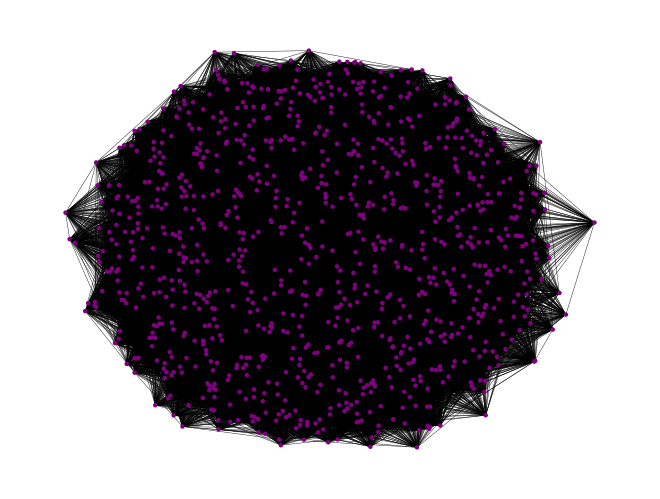

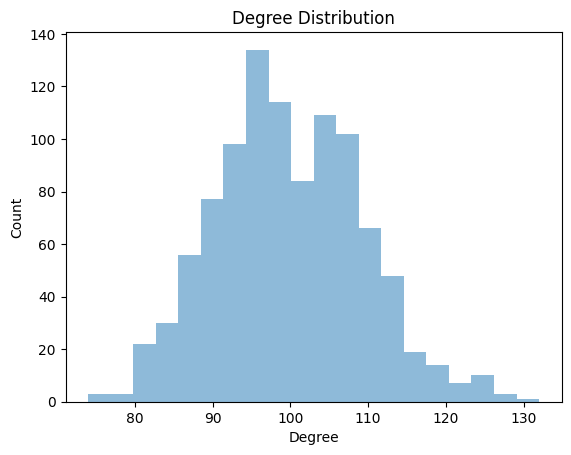

degree:
  Minimum: 74
  Maximum: 132
  Average: 99.778
degree centrality:
  Minimum: 0.07407407407407407
  Maximum: 0.13213213213213212
  Average: 0.09987787787787793
betweenness:
  Minimum: 0.0004932535650395632
  Maximum: 0.0015508753269379998
  Average: 0.0009019560642807126
closeness:
  Minimum: 0.518961038961039
  Maximum: 0.5353697749196141
  Average: 0.5262865639258475
average path length:
1.898252
longest path length:
3
diameter:
3
number of edges:
49889


In [1196]:
# Generate Erdos Renyi network
nodes = 1000
probability = 0.1
graph = nx.erdos_renyi_graph(nodes, probability)
plot_graph(graph)

statistics = get_graph_statistics(graph)

for statistic, values in statistics.items():
    print_statistics(statistic, values)


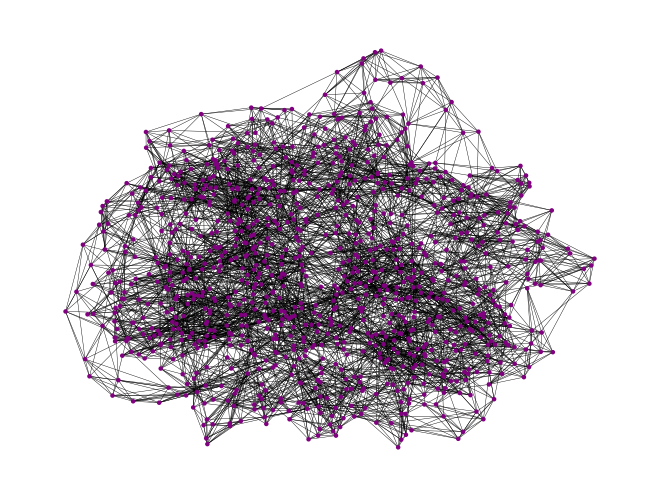

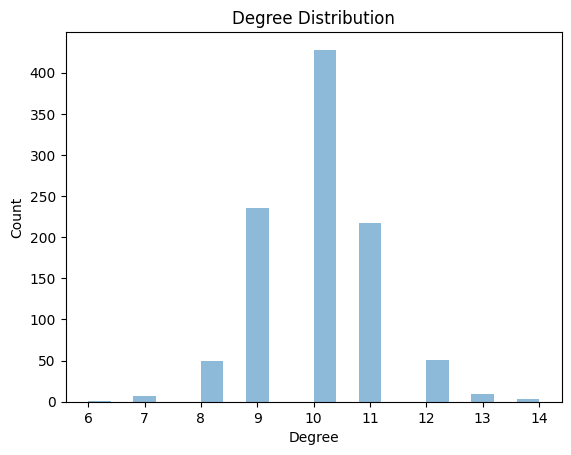

degree:
  Minimum: 6
  Maximum: 14
  Average: 10.0
degree centrality:
  Minimum: 0.006006006006006006
  Maximum: 0.014014014014014014
  Average: 0.01001001001001001
betweenness:
  Minimum: 0.0001554972738366738
  Maximum: 0.014253547276532047
  Average: 0.0033799330392516734
closeness:
  Minimum: 0.20056213611724552
  Maximum: 0.2628255722178374
  Average: 0.22910068572500833
average path length:
4.3688
longest path length:
7
diameter:
7
number of edges:
5000


In [1197]:
# Generate Watts Strogatz network
nodes = 1000
k = 10 
p = 0.1
graph = nx.watts_strogatz_graph(nodes, k, p)
plot_graph(graph)

statistics = get_graph_statistics(graph)

for statistic, values in statistics.items():
    print_statistics(statistic, values)


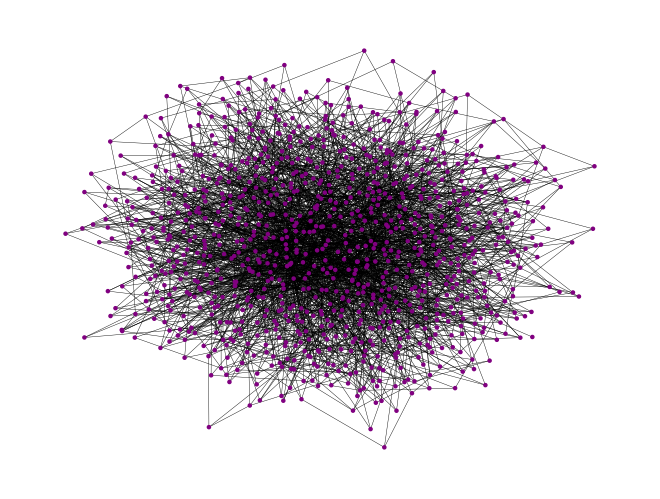

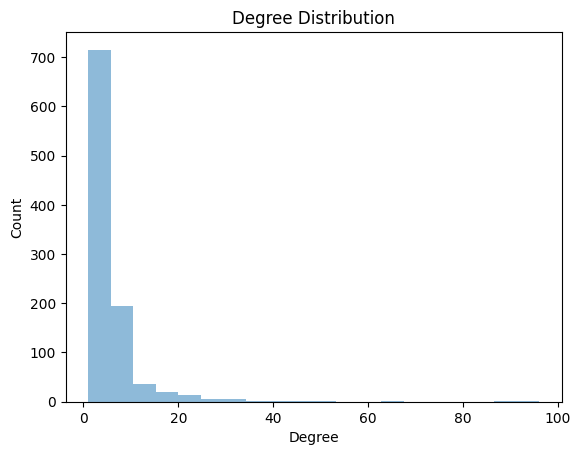

degree:
  Minimum: 1
  Maximum: 96
  Average: 5.982
degree centrality:
  Minimum: 0.001001001001001001
  Maximum: 0.0960960960960961
  Average: 0.00598798798798795
betweenness:
  Minimum: 0.0
  Maximum: 0.1658508236464152
  Average: 0.0025001474420312136
closeness:
  Minimum: 0.22960239025511378
  Maximum: 0.4391208791208791
  Average: 0.28862978508561565
average path length:
3.491652
longest path length:
6
diameter:
6
number of edges:
2991


In [1198]:
nodes = 1000
m = 3
graph = nx.barabasi_albert_graph(nodes, m)
plot_graph(graph)

statistics = get_graph_statistics(graph)

for statistic, values in statistics.items():
    print_statistics(statistic, values)

In [1199]:
def normalize(value, min_value, max_value):
    """
    Normalize a value to the range [0, 1] using the provided minimum and maximum values.

    Args:
        value (float): The value to be normalized.
        min_value (float): The minimum value of the range.
        max_value (float): The maximum value of the range.

    Returns:
        float: The normalized value within the range [0, 1].
    """

    if max_value == min_value:
        return 0.0
    return (value - min_value) / (max_value - min_value)


def calculate_similarity_score(er_properties, other_properties, statistics_to_compare):
    """
    Calculate the similarity score based on selected statistics between two sets of network properties.

    Args:
        er_properties (dict): A dictionary containing network properties for the reference Erdős-Rényi network.
        other_properties (dict): A dictionary containing network properties for another network.
        statistics_to_compare (list): A list of statistics to compare. Each statistic should be a key in the
        network properties dictionaries.

    Returns:
        float: The similarity score indicating the absolute difference in (normalized) averages of the selected statistics.

    The selected statistics are normalized to ensure that their values are within a common range before comparison.
    The similarity score is calculated as the sum of absolute differences between the normalized average values
    of selected statistics from the Erdős-Rényi network and the other network.
    This score provides a measure of how similar or dissimilar the networks are with respect to the chosen statistics.
    """

    similarity_score = 0

    for statistic in statistics_to_compare:
        if isinstance(er_properties[statistic], dict):
            er_stat = er_properties[statistic]["average"]
            other_stat = other_properties[statistic]["average"]

            # Normalize the average statistic within its range
            min_er = er_properties[statistic]["min"]
            max_er = er_properties[statistic]["max"]
            min_other = other_properties[statistic]["min"]
            max_other = other_properties[statistic]["max"]

            er_stat = normalize(er_stat, min_er, max_er)
            other_stat = normalize(other_stat, min_other, max_other)
        else:
            er_stat = er_properties[statistic]
            other_stat = other_properties[statistic]

        # Calculate the absolute difference between the (normalized) averages
        similarity_score += abs(er_stat - other_stat)

    return similarity_score


def find_best_parameters(statistics_to_compare, n, p_er):
    """
    Find the parameters for Barabási-Albert (BA) and Watts-Strogatz (WS) networks that result in the most similar characteristics
    of an Erdős-Rényi (ER) network with a given set of parameters.

    Args:
        statistics_to_compare (list): A list of statistics to compare between networks.
        n (int): The number of nodes in the ER network.
        p_er (float): The edge probability for the Erdős-Rényi network.

    Returns:
        tuple: A tuple containing the best parameters for BA and WS networks.
               (best_m: int, best_k: int, best_p: float)

    The function aims to find the best parameters for BA and WS networks that make them most similar to an ER network
    with respect to the selected network statistics.
    """

    er_network = nx.erdos_renyi_graph(n, p_er)
    er_properties = get_graph_statistics(er_network, plot_degree_distribution=False)

    best_m = 0
    best_similarity_score = np.inf

    for m in range(1, 50):
        ba_network = nx.barabasi_albert_graph(n, m)
        ba_properties = get_graph_statistics(ba_network, plot_degree_distribution=False)
        similarity_score = calculate_similarity_score(er_properties, ba_properties, statistics_to_compare)

        if similarity_score < best_similarity_score:
            best_similarity_score = similarity_score
            best_m = m

    best_k = 0
    best_p = 0
    best_similarity_score = np.inf

    for k in range(2, 11):
        for p in np.arange(0.01, 0.21, 0.01):
            ws_network = nx.watts_strogatz_graph(n, k, p)
            ws_properties = get_graph_statistics(ws_network, plot_degree_distribution=False)

            similarity_score = calculate_similarity_score(er_properties, ws_properties, statistics_to_compare)

            if similarity_score < best_similarity_score:
                best_similarity_score = similarity_score
                best_k = k
                best_p = p

    return best_m, best_k, round(best_p, 3)


In [1200]:
def compare_networks(initial_SIR, beta_gamma, nodes, p_er, best_m, best_p, best_k):
    """
    Compare the dynamics of infection spread on different types of networks (Erdős-Rényi, Watts-Strogatz, Barabási-Albert)
    for various combinations of beta and gamma values.

    Args:
        initial_SIR (list): Initial values for the SIR model parameters S, I and R.
        beta_gamma (list): List of lists containing pairs of beta and gamma values for comparison.
        nodes (int): Number of nodes in the networks.
        p_er (float): Edge probability for the Erdős-Rényi network.
        best_m (int): Best 'm' parameter for the Barabási-Albert network.
        best_p (float): Best 'p' parameter for the Watts-Strogatz network.
        best_k (int): Best 'k' parameter for the Watts-Strogatz network.

    Returns:
        tuple: A tuple of network objects for Erdős-Rényi, Watts-Strogatz, and Barabási-Albert networks.

    The function aims to compare the dynamics of infection spread on different types of networks (ER, WS, BA)
    for various combinations of beta and gamma values using the SIR model.
    """

    N_iterations = 200
    fig, axes = plt.subplots(2, 2)

    er_graph = nx.erdos_renyi_graph(nodes, p_er)

    for i in range(len(beta_gamma)):
        beta, gamma = beta_gamma[i][0], beta_gamma[i][1]
        model, iterations = infect_network(er_graph, beta, gamma, N_iterations, I_initial=initial_SIR[1])
        ax = axes[i//2, i%2]
        plot(iterations, ax)
        ax.set_title(fr"$\beta$ = {beta}, $\gamma$ = {gamma}")

    fig.suptitle(f"Dynamics infection spread on Erdos Renyi network with {nodes} nodes, p={p_er}")
    fig.tight_layout()
    plt.show()

    fig, axes = plt.subplots(2, 2)
    ws_graph = nx.watts_strogatz_graph(nodes, best_k, best_p)
    for i in range(len(beta_gamma)):
        beta, gamma = beta_gamma[i][0], beta_gamma[i][1]
        model, iterations = infect_network(ws_graph, beta, gamma, N_iterations, I_initial=initial_SIR[1])
        ax = axes[i//2, i%2]
        plot(iterations, ax)
        ax.set_title(fr"$\beta$ = {beta}, $\gamma$ = {gamma}")
    fig.suptitle(f"Dynamics infection spread on Watt Strogatz network with {nodes} nodes, k={best_k}, p={best_p}")
    fig.tight_layout()
    plt.show()

    fig, axes = plt.subplots(2, 2)
    ba_graph = nx.barabasi_albert_graph(nodes, best_m)
    for i in range(len(beta_gamma)):
        beta, gamma = beta_gamma[i][0], beta_gamma[i][1]
        model, iterations = infect_network(ba_graph, beta, gamma, N_iterations, I_initial=initial_SIR[1])
        ax = axes[i//2, i%2]
        plot(iterations, ax)
        ax.set_title(fr"$\beta$ = {beta}, $\gamma$ = {gamma}")
    fig.suptitle(f"Dynamics infection spread on Barabasi Albert network with {nodes} nodes, m={best_m}")
    fig.tight_layout()
    plt.show()

    return er_graph, ws_graph, ba_graph

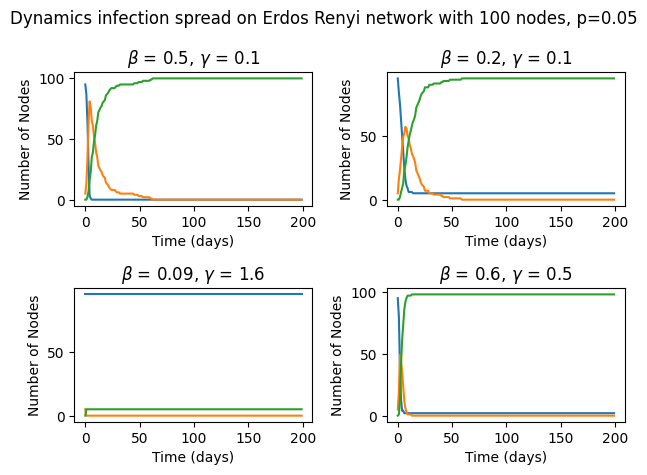

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

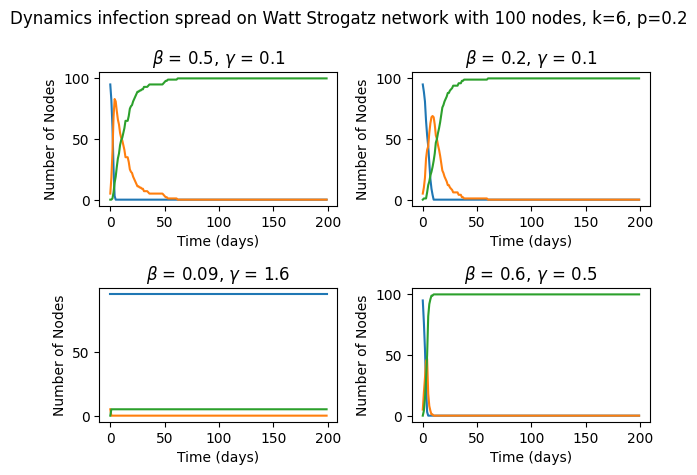

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

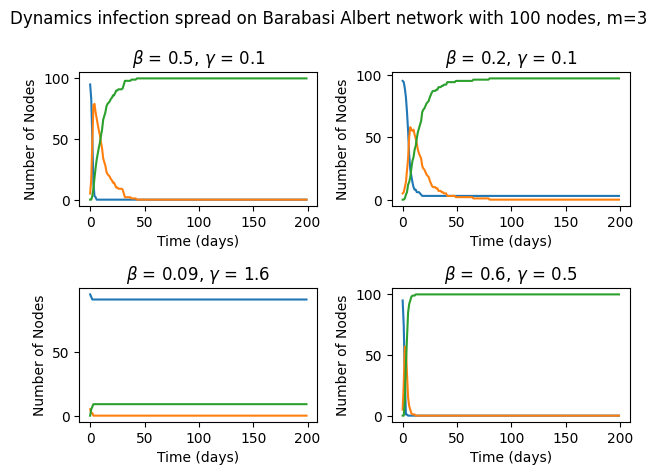

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [1201]:
networks = {}

# Define the statistics to compare
statistics_to_compare = ["degree centrality", "betweenness", "closeness", "average path length", "longest path length", "number of edges"]

nodes = 100
p_er = 0.05

best_m, best_k, best_p = find_best_parameters(statistics_to_compare, nodes, p_er)
er_graph, ws_graph, ba_graph = compare_networks(initial_SIR, beta_gamma, nodes, p_er, best_m, best_p, best_k)

new_networks = {"er": er_graph, "ba": ba_graph, "ws": ws_graph}
networks["_".join(statistics_to_compare)] = new_networks

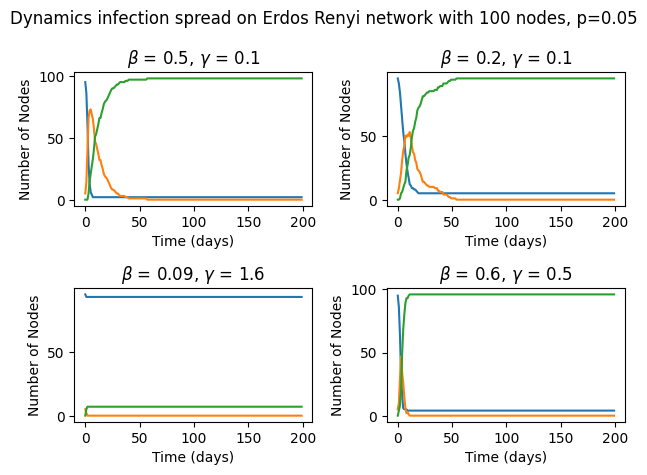

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

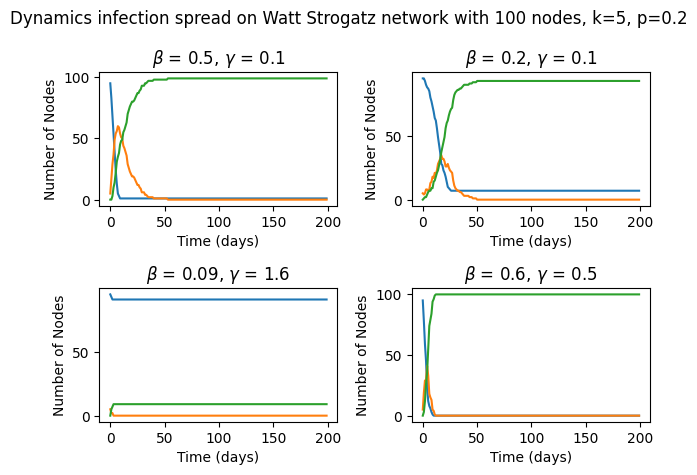

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

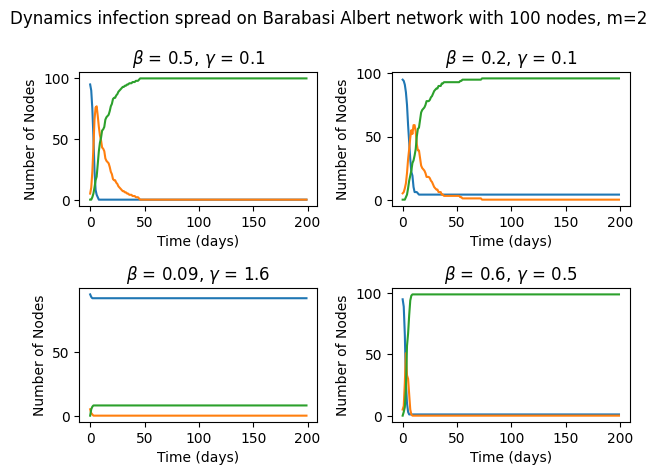

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [1202]:
# Define the statistics to compare
statistics_to_compare = ["average path length", "longest path length", "number of edges"]

nodes = 100
p_er = 0.05

best_m, best_k, best_p = find_best_parameters(statistics_to_compare, nodes, p_er)
er_graph, ws_graph, ba_graph = compare_networks(initial_SIR, beta_gamma, nodes, p_er, best_m, best_p, best_k)

new_networks = {"er": er_graph, "ba": ba_graph, "ws": ws_graph}
networks["_".join(statistics_to_compare)] = new_networks

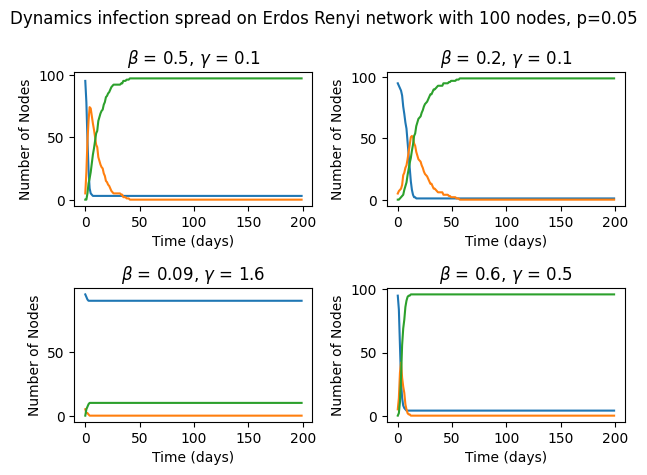

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

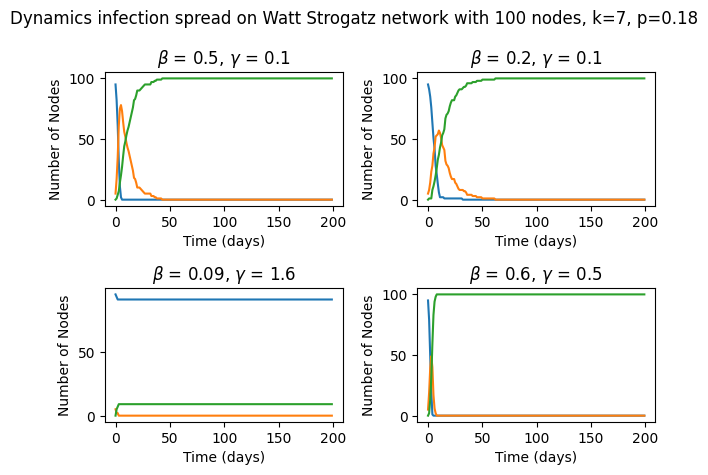

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

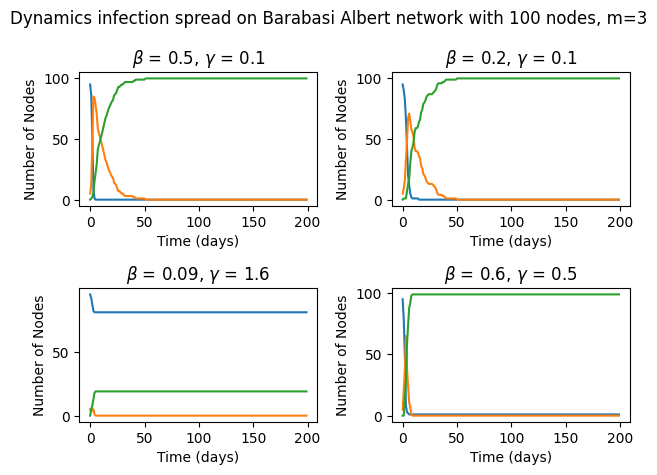

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [1203]:
# Define the statistics to compare
statistics_to_compare = ["degree centrality", "average path length", "number of edges"]

nodes = 100
p_er = 0.05

best_m, best_k, best_p = find_best_parameters(statistics_to_compare, nodes, p_er)
er_graph, ws_graph, ba_graph = compare_networks(initial_SIR, beta_gamma, nodes, p_er, best_m, best_p, best_k)

new_networks = {"er": er_graph, "ba": ba_graph, "ws": ws_graph}
networks["_".join(statistics_to_compare)] = new_networks

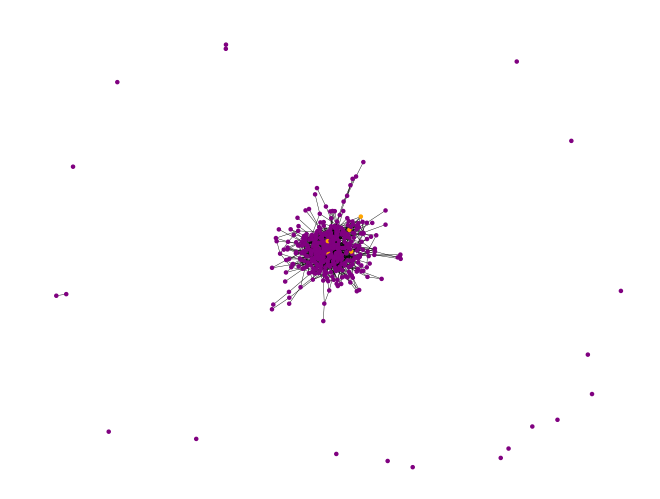

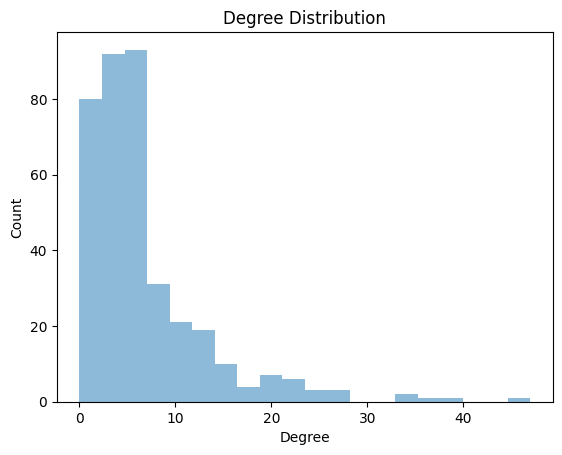

degree:
  Minimum: 0
  Maximum: 47
  Average: 6.764705882352941
degree centrality:
  Minimum: 0.0
  Maximum: 0.1260053619302949
  Average: 0.018135940703359003
betweenness:
  Minimum: 0.0
  Maximum: 0.11740266696539056
  Average: 0.005692021527266815
closeness:
  Minimum: 0.0
  Maximum: 0.40690911822043996
  Average: 0.27195340911127863
average path length:
3.353693952449338
longest path length:
9
diameter:
inf
number of edges:
1265


C:\Users\jaspe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ndlib\models\DiffusionModel.py:120: UserWarning: Initial infection missing: a random sample of 5% of graph nodes will be set as infected
  warnings.warn('Initial infection missing: a random sample of 5% of graph nodes will be set as infected')


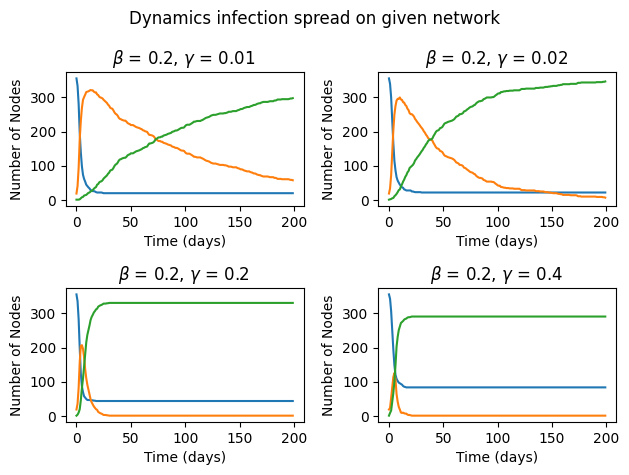

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [1204]:
filename = 'transmission_network.csv'
graph = read_data(filename)

initial_infected = list(sorted(graph.nodes))[100:105]
plot_graph(graph, initial_infected)
statistics = get_graph_statistics(graph)

for statistic, values in statistics.items():
    print_statistics(statistic, values)

np.random.seed(0)

initial_SIR= [500, 1, 0]
beta_gamma = [
    [0.2, 0.01],
    [0.2, 0.02],
    [0.2, 0.2],
    [0.2, 0.4]
    ]

N_iterations = 200
fig, axes = plt.subplots(2, 2)

for i in range(len(beta_gamma)):
    beta, gamma = beta_gamma[i][0], beta_gamma[i][1]
    model, iterations = infect_network(graph, beta, gamma, N_iterations, initial_infected)
    ax = axes[i//2, i%2]
    plot(iterations, ax)
    ax.set_title(fr"$\beta$ = {beta}, $\gamma$ = {gamma} ")

fig.suptitle("Dynamics infection spread on given network")
fig.tight_layout()
plt.show()